<div align='center'>
    <h2>Controle Quântico Ótimo</h2>
    <h4>Utilização do Algoritmo Genético para obtenção dos valores de controle</h4>
</div>

<div align='justify'>
    <p>Para que haja um controle ótimo de uma partícula, supondo que esta esteja em um estado inicial, é necessário formas de controle suficientemente eficientes já que a particula é a função de onda da partícula é definida em função do tempo. Para que isso seja possível utiliza-se a eficiência do algoritmo genético que pode usar ou não utilizar-se do elitismo juntamente com o controle preditivo, MPC. </p>
    <p>Abaixo são revelados os parâmetros para esse experimento, do qual podem ser ajustados:</p>
</div>

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp
import cmath
import time

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize
from random import randint, uniform, random

In [2]:
## CONSTANTES PARA O CONTROLADOR

# Considerações: constante de Planck verdadeira: 1, massa: 1

TEMPO_ANALISE = 10 
QUANTIDADE_PONTOS_AMOSTRAGEM = 100
PASSO = TEMPO_ANALISE/QUANTIDADE_PONTOS_AMOSTRAGEM

MIN_HORIZONTE = 3 # Horizonte mínimo da análise
MAX_HORIZONTE = 10 # Horizonte máximo da análise

ONDA_DESEJADA = [[complex(0.0,0.0)],[complex(1.0,0.0)]] # [[c1];[c2]] = [[0.707],[0.707]]

# Determinação dos valores de início e fim da análise
num = PASSO
contador = 0
while num < 1:
    num *= 10
    contador += 1

EXPOENTE = contador
INICIO_ANALISE = 0*10**(-EXPOENTE) # Tempo inicial da analise em um horizonte
FINAL_ANALISE = (1*10**(-EXPOENTE))+PASSO # Tempo final da analise em um horizonte

In [3]:
# Manipulação das matrizes, soma e subtração

def somar(A, B):
    C = []
    num_linhas_a = len(A)
    num_colunas_a = len(A[0])
    
    for i in range (num_linhas_a):
        linha = [0]*num_colunas_a
        C.append(linha)
        for j in range(num_colunas_a):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    num_linhas_a = len(A)
    num_colunas_a = len(A[0])
    
    for i in range (num_linhas_a):
        linha = [0]*num_colunas_a
        C.append(linha)
        for j in range(num_linhas_a):
            C[i][j] = A[i][j] - B[i][j]

    return C

<div align='justify'>
    <h4>Runge-Kutta de quarta ordem</h4>
    <p>Nos procedimentos com estados quânticos, é necessário utilizar-se da equação de Schrödinger com o o objetivo de avaliar o valor da função de onda com o tempo. Sabe-se que sua equação se dá pela função de onda relacionada com a posição e tempo, no entanto, utilizando a notação de Dirac, a posição se torna um atributo irrelevante para a análise já que analisaremos níveis. Portanto: </p>
</div>

$$\frac{\partial{\ket{\psi(t)}}}{\partial{t}} = -iH\ket{\psi(t)}$$


In [4]:
## psi' = -i * H * ket{psi}
def dpsi_dt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * ket{psi}

# Runge-Kutta de quarta ordem

def runge_kutta(onda, fator_runge_kutta, hamiltoniano, tempo_inicial = 0):
    
    # onda = [[c0],[c1]]
    
    k1 = dpsi_dt(tempo_inicial, onda, hamiltoniano)
    k2 = dpsi_dt(tempo_inicial + 0.5 * fator_runge_kutta, somar(onda, np.dot((0.5*fator_runge_kutta), k1)), hamiltoniano)
    k3 = dpsi_dt(tempo_inicial + 0.5 * fator_runge_kutta, somar(onda, np.dot((0.5*fator_runge_kutta), k2)), hamiltoniano)
    k4 = dpsi_dt(tempo_inicial + fator_runge_kutta, somar(onda, np.dot(fator_runge_kutta, k3)), hamiltoniano)
    
    ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
    
    A = somar(np.dot(2,k3), k4)
    B = somar(np.dot(2,k2), k1)
    C = somar(A, B)

    runge = somar(onda,np.dot((fator_runge_kutta / 6.0),(C)))
        
    return runge

<div align='justify'>
    <h4>Estabelecimento da função objetivo</h4>
    <p>O estudo se baseia em uma função de erro, da qual exije a comparação de um sistema de dois níveis em um certo tempo em relação ao seu desejado. Para que isso seja possível estabelece-se a noção de controle preditivo.</p>
    <p>O controle preditivo é um modelo que se utiliza da avaliação futura para reajustar uma curva em relação a sua referência, ou seja, esta família de controles tem a capacidade de visualizar instantes a frente para definir qual é a melhor rota. Com esse tipo de controle, a função objetivo estabelece-se da seguinte forma:</p>
</div>

$$\min ||\sum^{i+h}_{j = i} \ket{\psi(j)} - \ket{\psi_d(j)}||$$

In [5]:
def func_objetivo(x, it, onda_desejada, hamiltoniano, 
                  onda_inicial, horizonte, fator_runge_kutta):
    
    fo = 0
    runge = np.zeros((2,1),dtype=np.complex_)
        
    tempo = it   
    
    tempo_inicial = INICIO_ANALISE
    tempo_final = FINAL_ANALISE
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matriz_inicial = np.zeros((2,1),dtype=np.complex_)
    matriz_inicial = [[onda_inicial[0][0]], [onda_inicial[1][0]]] 

    matriz_desejada = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matriz_desejada[0][0] = onda_desejada[0][0]*np.exp(-1*complex(0,1)
                                                       *(1/2*np.pi)*tempo)
    matriz_desejada[1][0] = onda_desejada[1][0]*np.exp(-1*complex(0,1)
                                                       *(3/2*np.pi)*tempo)

    fo += (np.linalg.norm(matriz_inicial-matriz_desejada))**2

    runge = runge_kutta(matriz_inicial, fator_runge_kutta, 
                        somar(hamiltoniano, controles), 
                        tempo_inicial = tempo_inicial)

    matriz_inicial = runge

    tempo_inicial = round(tempo_inicial+PASSO, EXPOENTE)
    tempo_final = round(tempo_final+PASSO, EXPOENTE)
    tempo = round(tempo+PASSO, EXPOENTE)
    
    while horizonte > 1:
        
        matriz_desejada[0][0] = onda_desejada[0][0]*np.exp(-1*complex(0,1)
                                                           *(1/2*np.pi)*
                                                           tempo)
        matriz_desejada[1][0] = onda_desejada[1][0]*np.exp(
            -1*complex(0,1)*
            (3/2*np.pi)*tempo)
        
        fo += (np.linalg.norm(matriz_inicial-matriz_desejada))**2
        
        controles = [[0, x[len(x)-horizonte+1]], 
                     [x[len(x)-horizonte+1], 0]]

        runge = runge_kutta(matriz_inicial, fator_runge_kutta, somar
                            (hamiltoniano, controles), 
                            tempo_inicial = tempo_inicial)

        matriz_inicial = runge

        tempo_inicial = round(tempo_inicial+PASSO, EXPOENTE)
        tempo_final = round(tempo_final+PASSO, EXPOENTE)
        tempo = round(tempo+PASSO, EXPOENTE)
        horizonte -= 1
    
    return fo

<div align='justify'>
<p>Para o funcionamento do MPC, cria-se um looping de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.</p>
</div>

<div align='jusitfy'>
    <h4>Avaliação dos controladores</h4>
    <p>Como a função objetivo trata-se de uma minimização, é importante que o valor dos controladores tendam a zero de forma que a curva inicial alcance a desejada. Para isso, plota-se os valores da função objetivo com os controladores.</p>
</div>

In [6]:
def vfo(valor):
    ts = np.linspace(0, TEMPO_ANALISE, QUANTIDADE_PONTOS_AMOSTRAGEM)

    plt.ylabel('Função Objetivo') 
    plt.xlabel('Tempo') 
    plt.plot(ts, abs(valor[0])/abs(valor[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Valor da FO")
    plt.legend(loc="upper right")
    plt.show()

<div align='jusitfy'>
    <h4>Avaliação das componentes</h4>
    <p>Um grande problemas dos métodos de minimização está concentrado no cálculo numérico. O cálculo númerico se trata de um processo de aproximação de forma que quanto pior é a manipulação das variáveis, pior ficará a aproximação. Nesse sistema se torna perceptível a melhoria do ajuste através da desafagem de uma curva em relação a outra.</p>
    <p>Conforme o livro, introdução à computação clássica e quântica de Thomas Wong (2022), a defasagem apresentada por um sistema quântico não tem significado físico se for a mesma para todo o sistema, ou seja, todas as componentes devem ter a mesma diferença de fases. Para realizar essa avaliação, se faz necessário propor uma diferença entre a curva original e o destino, tanto na primeira componente quanto na segunda, além de realizar a diferença entre essas partes.</p>
    
</div>

In [7]:
def evolucao_desejada():
    evolucao_d = np.zeros((2,QUANTIDADE_PONTOS_AMOSTRAGEM), dtype=np.complex_)
    
    tempo = 0
    pos = 0
    while tempo < TEMPO_ANALISE:
        
        evolucao_d[0][pos] = (ONDA_DESEJADA[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo))
        evolucao_d[1][pos] = (ONDA_DESEJADA[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo))
    
        tempo = round(tempo+PASSO, EXPOENTE)
        pos += 1
        
    return evolucao_d

In [8]:
def plot_componentes(valores_onda, evolucao_d, componente):
    
    ts = np.linspace(0, TEMPO_ANALISE, QUANTIDADE_PONTOS_AMOSTRAGEM)
    
    real_inicial = [elemento.real for elemento in valores_onda[componente-1]]
    imaginario_inicial = [elemento.imag for elemento in valores_onda[componente-1]]
    
    real_desejado = [elemento.real for elemento in evolucao_d[componente-1]]
    imaginario_desejado = [elemento.imag for elemento in evolucao_d[componente-1]]
    
    # Plotagem
    plt.subplot(2,1,1)

    plt.ylabel('Pesos') 
    plt.xlabel('Tempo') 
    plt.title(f"{componente}ª componente -> real")
    plt.plot(ts, real_inicial, color='r', marker='*', linewidth=1, markersize=1, label="Inicial")
    plt.plot(ts, real_desejado, color='b', marker='o',  linewidth=1, markersize=1, label="Desejado")
    plt.legend(loc='upper right')
    
    plt.subplot(2,1,2)

    plt.ylabel('Imaginário') 
    plt.xlabel('Tempo') 
    plt.title(f"{componente}ª componente -> imaginária")
    plt.plot(ts, imaginario_inicial, color='r', marker='*', linewidth=1, markersize=1, label="Inicial")
    plt.plot(ts, imaginario_desejado, color='b', marker='o',  linewidth=1, markersize=1, label="Desejado")
    plt.legend(loc='upper right')

    plt.tight_layout()

<div align='justify'>
    <h4>Gráficos - Avaliação da densidade de probabilidade para encontrar uma partícula no ponto x</h4>
    <p> Conforme descrito durante os capítulos 1, 2 e 3 do livro Mecânica Quântica por David Griffths, a estatística é um dos principais pontos para o entendimento da mecânica quântica, dessa forma é interessante entender qual é a probabilidade de uma partícula estar em um determinado lugar em um certo tempo e para tal se define:</p>
</div>

$$\int |\Psi(x,t)|^{2}dx = 1$$ 

<div align='justify'>
    <p>Ainda nessa perspectiva, foi definido que o resultado da equação de Schrödinger pode ser definido a partir da escolha do potêncial V(x,t) e ainda que os enumeros resultados podem formar outros por meio de uma combinação linear de forma que o conjunto do quadrado das constantes que o formam, em sua soma resultam em 1. Isso define a probabilidade de um estado. Para este estudo considerou-se dois estados:</p>
</div>

$$0,80\psi_0(x,t)+0,60\psi_1(x,t)$$

<div align='justify'>
    <p>de forma que para o primeiro estado a probabilidade é de 64% enquanto para o segundo é de 36%.</p>
</div>

In [9]:
def probabilidade(constantes):
    
    ts = np.linspace(0, TEMPO_ANALISE, QUANTIDADE_PONTOS_AMOSTRAGEM)
    
    dp = []
    for i in range(0, QUANTIDADE_PONTOS_AMOSTRAGEM):
        dp.append((abs(constantes[0][i])**2+abs(constantes[1][i])**2))

    plt.ylabel('Densidade probabilidade') 
    plt.xlabel('Tempo') 
    plt.plot(ts, dp, color='r', marker='*', linewidth=1, markersize=1, label="Valor do somatório das constantes")
    plt.legend(loc="upper right")
    plt.show()

<div align='justify'>
    <h4>Programa principal</h4>
    <p>O programa principal utiliza a onda inicial e o horizonte desejado para encontrar o melhor valor para controladores por meio de um laço que chama, a todo momento, as funções observadas acima.</p>
</div>

In [10]:
def main(horizonte, onda_inicial):
    
    u = [] # Controladores iniciais
    u.append(uniform(-5,5))
    while len(u) < horizonte:
        u.append(u[0])
        
    # O que será retornado por essa função
    
    vetor_controles = np.zeros((1, QUANTIDADE_PONTOS_AMOSTRAGEM), dtype=np.complex_) # Valores de controle
    valores_funcao_objetivo = np.zeros((1, QUANTIDADE_PONTOS_AMOSTRAGEM), dtype=np.complex_) # Utilização do controle para comparação com o valor esperado
    constantes = np.zeros((2, QUANTIDADE_PONTOS_AMOSTRAGEM), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
    valores_onda = np.zeros((2, QUANTIDADE_PONTOS_AMOSTRAGEM), dtype=np.complex_)
    
    hamiltoniano = np.zeros((2,2), dtype=np.complex_)
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    tempo = 0
    pos = 0
    while tempo < TEMPO_ANALISE:

        if (pos%100 == 0):
            print(f"Iteração: {pos+1}")
        
        # Variação do Psi
        valores_onda[0][pos] = onda_inicial[0][0]
        valores_onda[1][pos] = onda_inicial[1][0]
        
        # Obtenção das constantes que multiplicam Psi
        # C_0 = Psi_0/[e^(1/2*pi*tempo)] equação 2.18 Griffiths
        constantes[0][pos] = onda_inicial[0][0]/np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        constantes[1][pos] = onda_inicial[1][0]/np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        ## Minimização
    
        resultado = optimize.minimize(func_objetivo, u, args=(tempo, ONDA_DESEJADA, hamiltoniano, onda_inicial, horizonte, PASSO), method='BFGS')
        
        # Função objetivo

        if resultado.x[0] >= 5:
            resultado.x[0] = 5
        elif resultado.x[0] <= -5:
            resultado.x[0] = -5

        vetor_controles[0][pos] = resultado.x[0]

        valores_funcao_objetivo[0][pos] = func_objetivo(resultado.x, tempo, ONDA_DESEJADA, hamiltoniano, onda_inicial, horizonte, PASSO)
        
        controle = np.zeros((2,1), dtype=np.complex_)
        controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
        hamiltoniano = somar(hamiltoniano, controle)

        ## Adaptação da onda ao controle

        onda_avancada = np.zeros((2,2), dtype=np.complex_)
        onda_avancada = runge_kutta(onda_inicial, PASSO, hamiltoniano, tempo_inicial = INICIO_ANALISE)

        onda_inicial[0][0] = onda_avancada[0][0]
        onda_inicial[1][0] = onda_avancada[1][0]

        # Reset
        hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

        u = [] # Controladores iniciais
        while len(u) < horizonte:
            u.append(resultado.x[0])
        
        pos += 1
        tempo = round(tempo+PASSO, EXPOENTE)
    
    return vetor_controles, valores_funcao_objetivo, constantes, valores_onda
    

<div align='justify'>
    <h4>Variação dos horizontes</h4>
    <p>Como será observado a frente, a variação dos horizontes auxiliam na melhoria da defasagem apresentada pelo sistema, no entanto isso gera complicações no custo computacional.</p>
</div>

In [11]:
desejo = evolucao_desejada()

onda_inicial = [[complex(1.0,0.0)],[complex(0.0,0.0)]]

vetor_controles, valores_funcao_objetivo, constantes, valores_onda = main(10, onda_inicial)

Iteração: 1


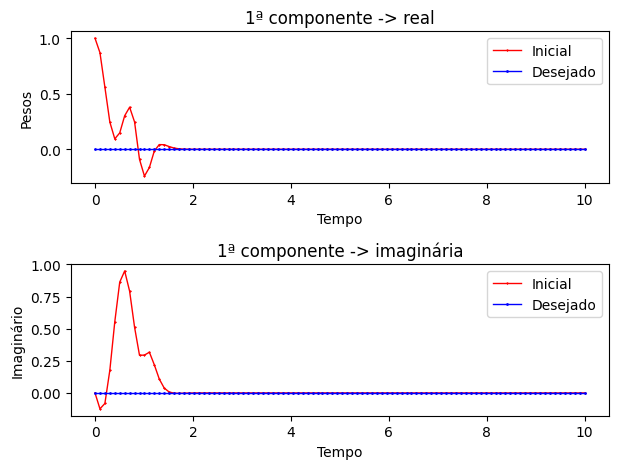

In [12]:
plot_componentes(valores_onda, desejo, 1)

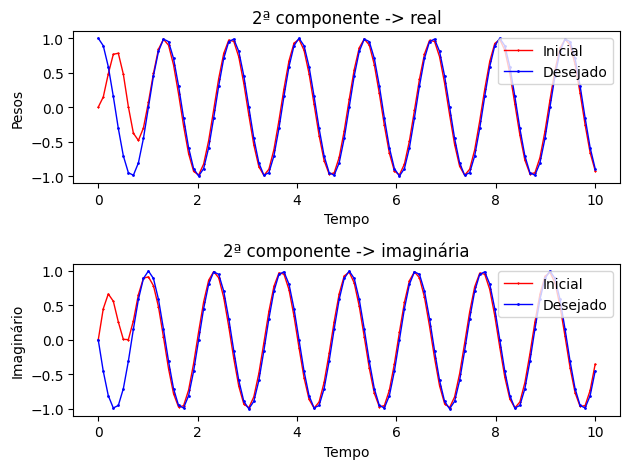

In [13]:
plot_componentes(valores_onda, desejo, 2)

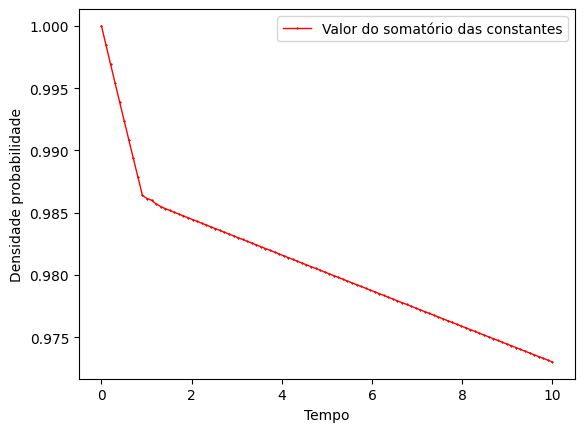

In [14]:
probabilidade(constantes)

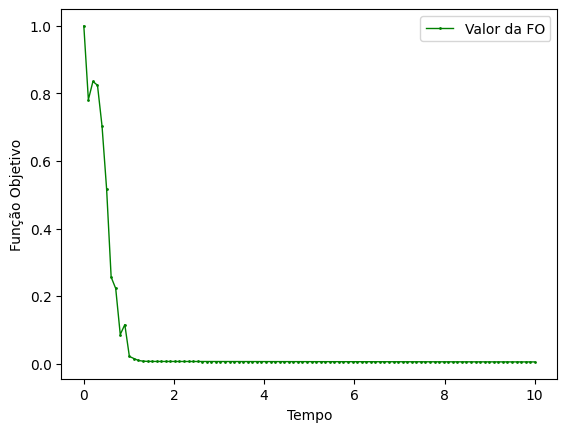

In [15]:
vfo(valores_funcao_objetivo)

In [16]:
def acao_controle(valor):
    ts = np.linspace(0, TEMPO_ANALISE, QUANTIDADE_PONTOS_AMOSTRAGEM)

    plt.ylabel('Ação de controle')
    plt.xlabel('Tempo')
    plt.plot(ts, valor, color='k', marker='o', linewidth=1, markersize=1, label="Valor da ação de controle")
    plt.legend(loc="upper right")
    plt.show()

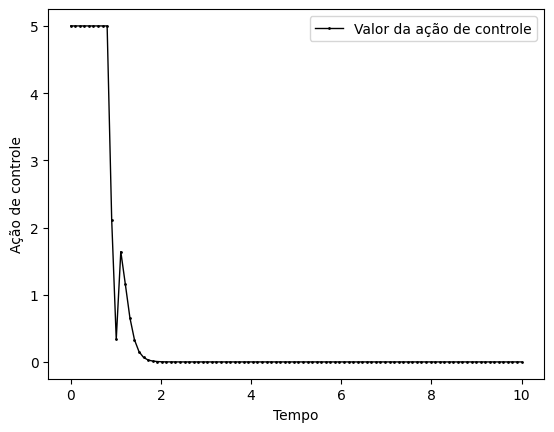

In [17]:
acao_controle(abs(vetor_controles[0]))

%%%_Horizonte 3_%%%%


Iteração: 1
Norma do máximo: 0.857645848735034


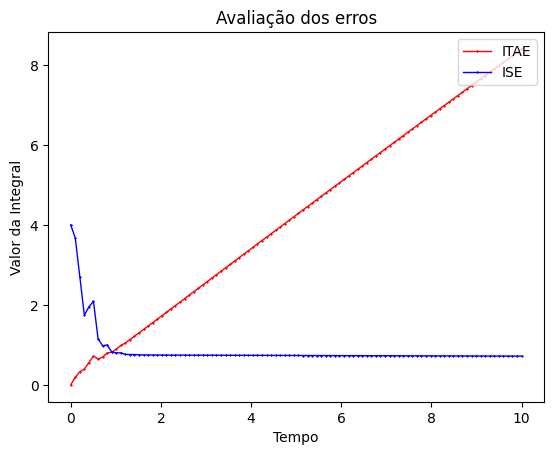

ITAE: 42.439596424280765
ISE: 8.48390969365257
-------------------
%%%_Horizonte 4_%%%%


Iteração: 1
Norma do máximo: 0.6299850402645116


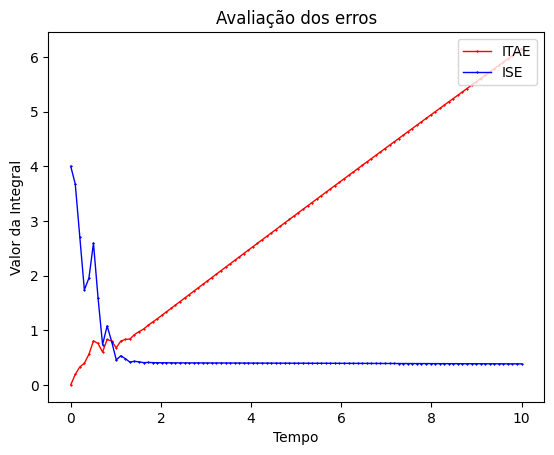

ITAE: 31.30529635706382
ISE: 5.5176442429455275
-------------------
%%%_Horizonte 5_%%%%


Iteração: 1
Norma do máximo: 0.48866684199251176


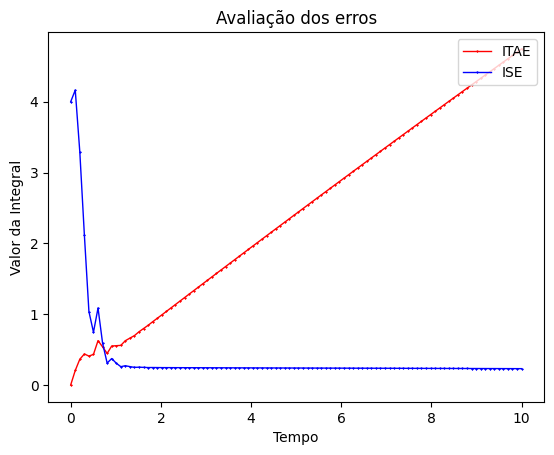

ITAE: 24.231681900099737
ISE: 3.752022080041584
-------------------
%%%_Horizonte 6_%%%%


Iteração: 1
Norma do máximo: 0.12740986935701798


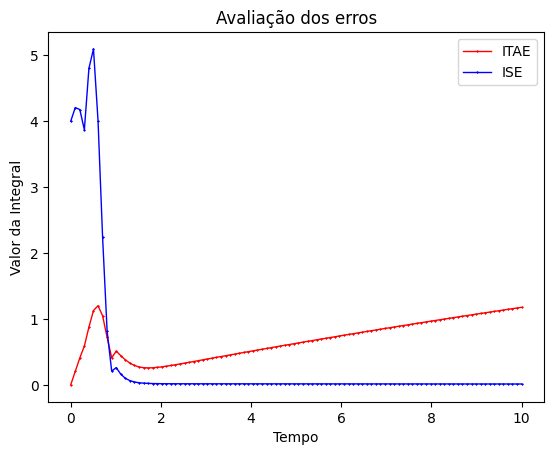

ITAE: 6.9119684907129315
ISE: 3.379600181479635
-------------------
%%%_Horizonte 7_%%%%


Iteração: 1
Norma do máximo: 0.11914887910950481


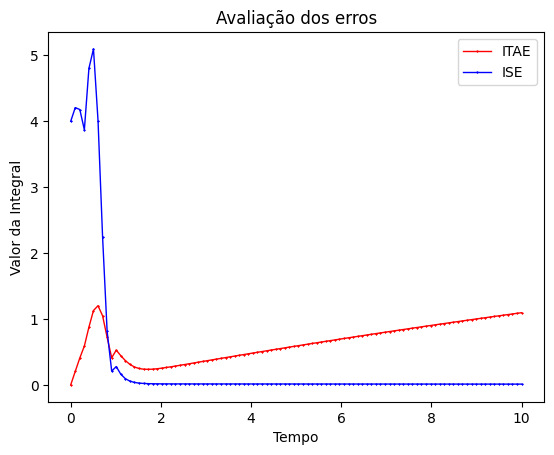

ITAE: 6.503733119820556
ISE: 3.3608897141009484
-------------------
%%%_Horizonte 8_%%%%


Iteração: 1
Norma do máximo: 0.09835095796631568


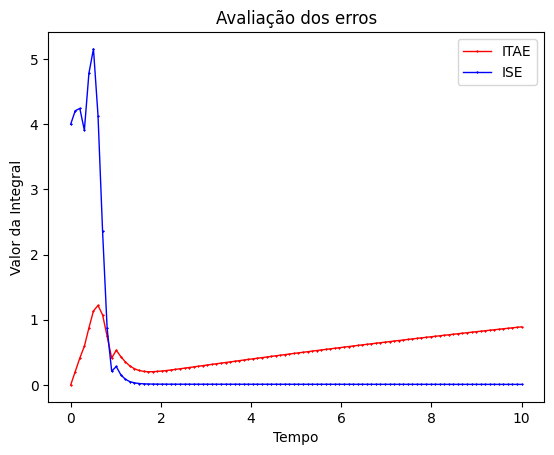

ITAE: 5.500681273492175
ISE: 3.362149473889268
-------------------
%%%_Horizonte 9_%%%%


Iteração: 1
Norma do máximo: 0.10699464804309355


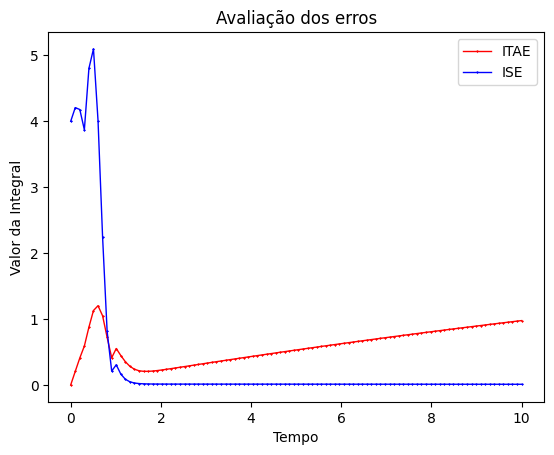

ITAE: 5.904876951450191
ISE: 3.3366128158633637
-------------------
%%%_Horizonte 10_%%%


Iteração: 1
Norma do máximo: 0.11308183424032021


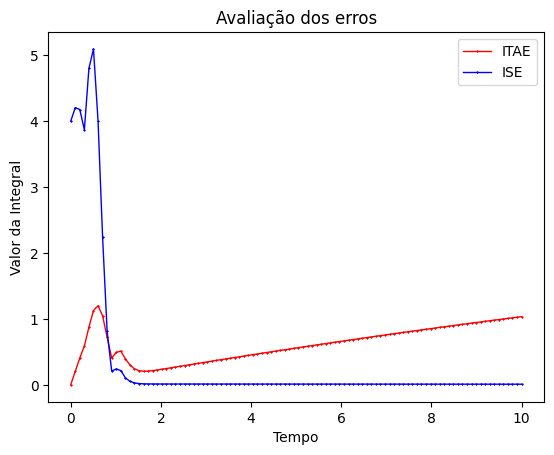

ITAE: 6.20371976751471
ISE: 3.3498196788488643
-------------------
--- 26.463716506958008 seconds ---


In [18]:
from scipy.integrate import trapezoid

i = MIN_HORIZONTE

start_time = time.time()

ts = np.linspace(0, TEMPO_ANALISE, QUANTIDADE_PONTOS_AMOSTRAGEM)

defasagem = []
erro = []

while i <= MAX_HORIZONTE:

    desejo = evolucao_desejada()

    onda_inicial = [[complex(1.0,0.0)],[complex(0.0,0.0)]]

    str = f"_Horizonte {i}_"
    print(f"{str.center(20, '%')}\n\n")
    
    vetor_controles, valores_funcao_objetivo, constantes, valores_onda = main(i, onda_inicial)

    if (onda_inicial[1][0] > ONDA_DESEJADA[1][0]):
        defasagem.append(cmath.polar(min(valores_onda[0]/
                                         desejo[0]))[1])
    else:
        defasagem.append(cmath.polar(min(desejo[0]/
                                         valores_onda[0]))[1]) 
    # Gera uma matriz erro 2x2
    erro = (np.subtract(valores_onda,desejo)) # É necessário dividir pelo tamanho do horizonte?
    
    norm_erro = []	
    pos = 0
    # Norma
    while pos < QUANTIDADE_PONTOS_AMOSTRAGEM:
        norm_erro.append(abs(erro[0][pos])+abs(erro[1][pos]))
        pos+=1

    print(f"Norma do máximo: {max(norm_erro[50:99])}")
    tempo = 0 
    pos = 0
    ise = []
    itae = []
    
    while tempo < TEMPO_ANALISE:
        
        itae.append(tempo*(norm_erro[pos]))
        
        ise.append((norm_erro[pos])**2)
        
        pos += 1
        tempo = round(tempo+PASSO, EXPOENTE)

    plt.ylabel('Valor da Integral') 
    plt.xlabel('Tempo') 
    plt.title('Avaliação dos erros')
    
    plt.plot(ts, itae, color='r', marker='*', linewidth=1, markersize=1, label="ITAE")
    plt.plot(ts, ise, color='b', marker='*', linewidth=1, markersize=1, label="ISE")
    plt.legend(loc='upper right')
    plt.show()
    
    print(f"ITAE: {trapezoid(itae, ts)}")
    print(f"ISE: {trapezoid(ise, ts)}")
    print("-------------------")
    
    if i >= 10:
        i+=10
    else:
        i+=1

print("--- %s seconds ---" % (time.time() - start_time))